# Compare ward boundaries with CCGs

We know that Clinical Commissioning Groups (CCGs) and so Sub-Integrated Care Board Locations (SICBLs) are built up from LSOA boundaries. This notebook checks to see if we can build them up from ward boundaries instead.

## Notebook setup

In [1]:
# For handling the tabular data:
import pandas as pd
# For maps:
import geopandas
import matplotlib.pyplot as plt

# For tracking paths to files:
import os
from dataclasses import dataclass

from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    # Directories:
    dir_ons_tabular = '../data_tabular/ons_data/'
    dir_tabular = '../data_tabular/'
    dir_ons_geojson = '../data_geojson/ons_data/'
    dir_output = 'output_data'
    dir_output_images = 'output_images'

    # Tabular data:
    sicbl_icb = 'LOC22_ICB22_NHSER22_EN_LU.csv'
    lad_country = 'Local_Authority_District_to_Country_(December_2022)_Lookup_in_the_United_Kingdom.csv'
    sicbl_lad = 'LSOA11_LOC22_ICB22_LAD22_EN_LU.csv'
    ccg_ambo = 'ambulance_service_info_ccg_lookup.csv'
    ccg_sicbl = 'ccg_stp_sicbl_icb.csv'

    # Boundaries data:
    ward15_geojson = 'CMWD_Dec_2011_GCB_in_England_and_Wales_2022.geojson'
    # ward15_geojson = 'Wards_December_2011_GCB_EW_2022.geojson'
    # ward15_geojson = 'Wards_December_2015_GCB_in_Great_Britain_2022.geojson'
    ccg15_geojson = 'Clinical_Commissioning_Groups_July_2015_GCB_in_England_2022.geojson'

    # Output:
    df_output = 'ward11_ccg15.csv'
    image_output = 'boundaries_censusmeanward11_ccg15.png'

paths = Paths()

In [3]:
region_code = 'cmwd11cd'

## Import region files

In [4]:
gdf_ward = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ward15_geojson))
gdf_ccg = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [5]:
gdf_ccg.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [6]:
gdf_ward.head(3)

,OBJECTID,cmwd11cd,cmwd11nm,cmwd11nmw,lad11cd,lad11nm,lad11nmw,GlobalID,geometry
0,1,E36000001,Brus,,E06000001,Hartlepool,,5140fa27-4510-422d-8381-c1cbd2bb4d58,"POLYGON ((451002.399 535163.000, 450871.100 53..."
1,2,E36000002,Burn Valley,,E06000001,Hartlepool,,3eb5ef96-8689-485e-a50c-a1934765e018,"POLYGON ((450358.899 532312.199, 450393.299 53..."
2,3,E36000003,Dyke House,,E06000001,Hartlepool,,39e2dc71-e7e5-420e-bf8f-cb288a1d0bc2,"POLYGON ((450629.700 533989.900, 450865.800 53..."


Find ward centroids:

In [7]:
gdf_ward['centroid'] = gdf_ward['geometry'].centroid

In [8]:
gdf_ward.head(3)

,OBJECTID,cmwd11cd,cmwd11nm,cmwd11nmw,lad11cd,lad11nm,lad11nmw,GlobalID,geometry,centroid
0,1,E36000001,Brus,,E06000001,Hartlepool,,5140fa27-4510-422d-8381-c1cbd2bb4d58,"POLYGON ((451002.399 535163.000, 450871.100 53...",POINT (449952.378 535045.666)
1,2,E36000002,Burn Valley,,E06000001,Hartlepool,,3eb5ef96-8689-485e-a50c-a1934765e018,"POLYGON ((450358.899 532312.199, 450393.299 53...",POINT (450060.422 531820.818)
2,3,E36000003,Dyke House,,E06000001,Hartlepool,,39e2dc71-e7e5-420e-bf8f-cb288a1d0bc2,"POLYGON ((450629.700 533989.900, 450865.800 53...",POINT (450345.268 533597.897)


Find representative points:

In [9]:
gdf_ward['representative_point'] = gdf_ward['geometry'].representative_point()

In [10]:
gdf_ward.head(3)

,OBJECTID,cmwd11cd,cmwd11nm,cmwd11nmw,lad11cd,lad11nm,lad11nmw,GlobalID,geometry,centroid,representative_point
0,1,E36000001,Brus,,E06000001,Hartlepool,,5140fa27-4510-422d-8381-c1cbd2bb4d58,"POLYGON ((451002.399 535163.000, 450871.100 53...",POINT (449952.378 535045.666),POINT (450042.275 535108.351)
1,2,E36000002,Burn Valley,,E06000001,Hartlepool,,3eb5ef96-8689-485e-a50c-a1934765e018,"POLYGON ((450358.899 532312.199, 450393.299 53...",POINT (450060.422 531820.818),POINT (450027.042 531805.450)
2,3,E36000003,Dyke House,,E06000001,Hartlepool,,39e2dc71-e7e5-420e-bf8f-cb288a1d0bc2,"POLYGON ((450629.700 533989.900, 450865.800 53...",POINT (450345.268 533597.897),POINT (450382.667 533597.151)


For each ward point, check if each CCG polygon contains it:

In [11]:
dict_ward_ccg = {}

for ind in gdf_ward.index:
    series_bool = gdf_ccg['geometry'].contains(gdf_ward.loc[ind, 'representative_point'])
    
    ccg_ind = series_bool[series_bool == True].index
    try:
        ccg_name = gdf_ccg.loc[ccg_ind, 'ccg15cd'].values[0]
        ward_name = gdf_ward.loc[ind, region_code]
        
        dict_ward_ccg[ward_name] = ccg_name
    except IndexError:
        # This ward isn't in any CCG.
        pass

In [12]:
series_ward_ccg = pd.Series(dict_ward_ccg)
series_ward_ccg.index.name = region_code
series_ward_ccg.name = 'ccg15cd'

In [13]:
series_ward_ccg

cmwd11cd
E36000001    E38000075
E36000002    E38000075
E36000003    E38000075
E36000004    E38000075
E36000005    E38000075
               ...    
E36007674    E38000031
E36007675    E38000031
E36007676    E38000031
E36007677    E38000031
E36007678    E38000202
Name: ccg15cd, Length: 7678, dtype: object

In [14]:
gdf_ward = pd.merge(
    gdf_ward, series_ward_ccg,
    left_on=region_code, right_index=True, how='right'
)

In [15]:
gdf_ward.head(3)

,OBJECTID,cmwd11cd,cmwd11nm,cmwd11nmw,lad11cd,lad11nm,lad11nmw,GlobalID,geometry,centroid,representative_point,ccg15cd
0,1,E36000001,Brus,,E06000001,Hartlepool,,5140fa27-4510-422d-8381-c1cbd2bb4d58,"POLYGON ((451002.399 535163.000, 450871.100 53...",POINT (449952.378 535045.666),POINT (450042.275 535108.351),E38000075
1,2,E36000002,Burn Valley,,E06000001,Hartlepool,,3eb5ef96-8689-485e-a50c-a1934765e018,"POLYGON ((450358.899 532312.199, 450393.299 53...",POINT (450060.422 531820.818),POINT (450027.042 531805.450),E38000075
2,3,E36000003,Dyke House,,E06000001,Hartlepool,,39e2dc71-e7e5-420e-bf8f-cb288a1d0bc2,"POLYGON ((450629.700 533989.900, 450865.800 53...",POINT (450345.268 533597.897),POINT (450382.667 533597.151),E38000075


Assign a colour to each CCG:

In [16]:
# Assign colour numbers.
# Use 'distance' balance to use as few colours as possible.
gdf_ccg['adjacent_colours'] = greedy(
    gdf_ccg, min_distance=1,
    # balance='distance',
    balance='count',
).astype(str)

In [17]:
# Make a list of colour names:
# Expecting to only need about six colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

In [18]:
# Assign these colours to the regions:
gdf_ccg['colour_str'] = gdf_ccg['adjacent_colours'].map(colour_map)

In [19]:
gdf_ccg.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry,adjacent_colours,colour_str
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48...",4,Orchid
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15...",2,DarkOrchid
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24...",2,DarkOrchid


Copy over the colours to the ward data:

In [20]:
colour_series = gdf_ccg[['ccg15cd', 'colour_str']]

In [21]:
colour_series

,ccg15cd,colour_str
0,E38000001,Orchid
1,E38000002,DarkOrchid
2,E38000003,DarkOrchid
3,E38000004,DarkOrchid
4,E38000005,Purple
...,...,...
204,E38000210,MediumOrchid
205,E38000211,Plum
206,E38000212,Orchid
207,E38000213,Orchid


In [22]:
gdf_ward = pd.merge(gdf_ward, colour_series, on='ccg15cd', how='left')

In [23]:
gdf_ward.head(3)

,OBJECTID,cmwd11cd,cmwd11nm,cmwd11nmw,lad11cd,lad11nm,lad11nmw,GlobalID,geometry,centroid,representative_point,ccg15cd,colour_str
0,1,E36000001,Brus,,E06000001,Hartlepool,,5140fa27-4510-422d-8381-c1cbd2bb4d58,"POLYGON ((451002.399 535163.000, 450871.100 53...",POINT (449952.378 535045.666),POINT (450042.275 535108.351),E38000075,Purple
1,2,E36000002,Burn Valley,,E06000001,Hartlepool,,3eb5ef96-8689-485e-a50c-a1934765e018,"POLYGON ((450358.899 532312.199, 450393.299 53...",POINT (450060.422 531820.818),POINT (450027.042 531805.450),E38000075,Purple
2,3,E36000003,Dyke House,,E06000001,Hartlepool,,39e2dc71-e7e5-420e-bf8f-cb288a1d0bc2,"POLYGON ((450629.700 533989.900, 450865.800 53...",POINT (450345.268 533597.897),POINT (450382.667 533597.151),E38000075,Purple


## Plot map

Make a map where the CCG boundaries are outlined and the ward boundaries are coloured in according to the CCG we think each belongs to.

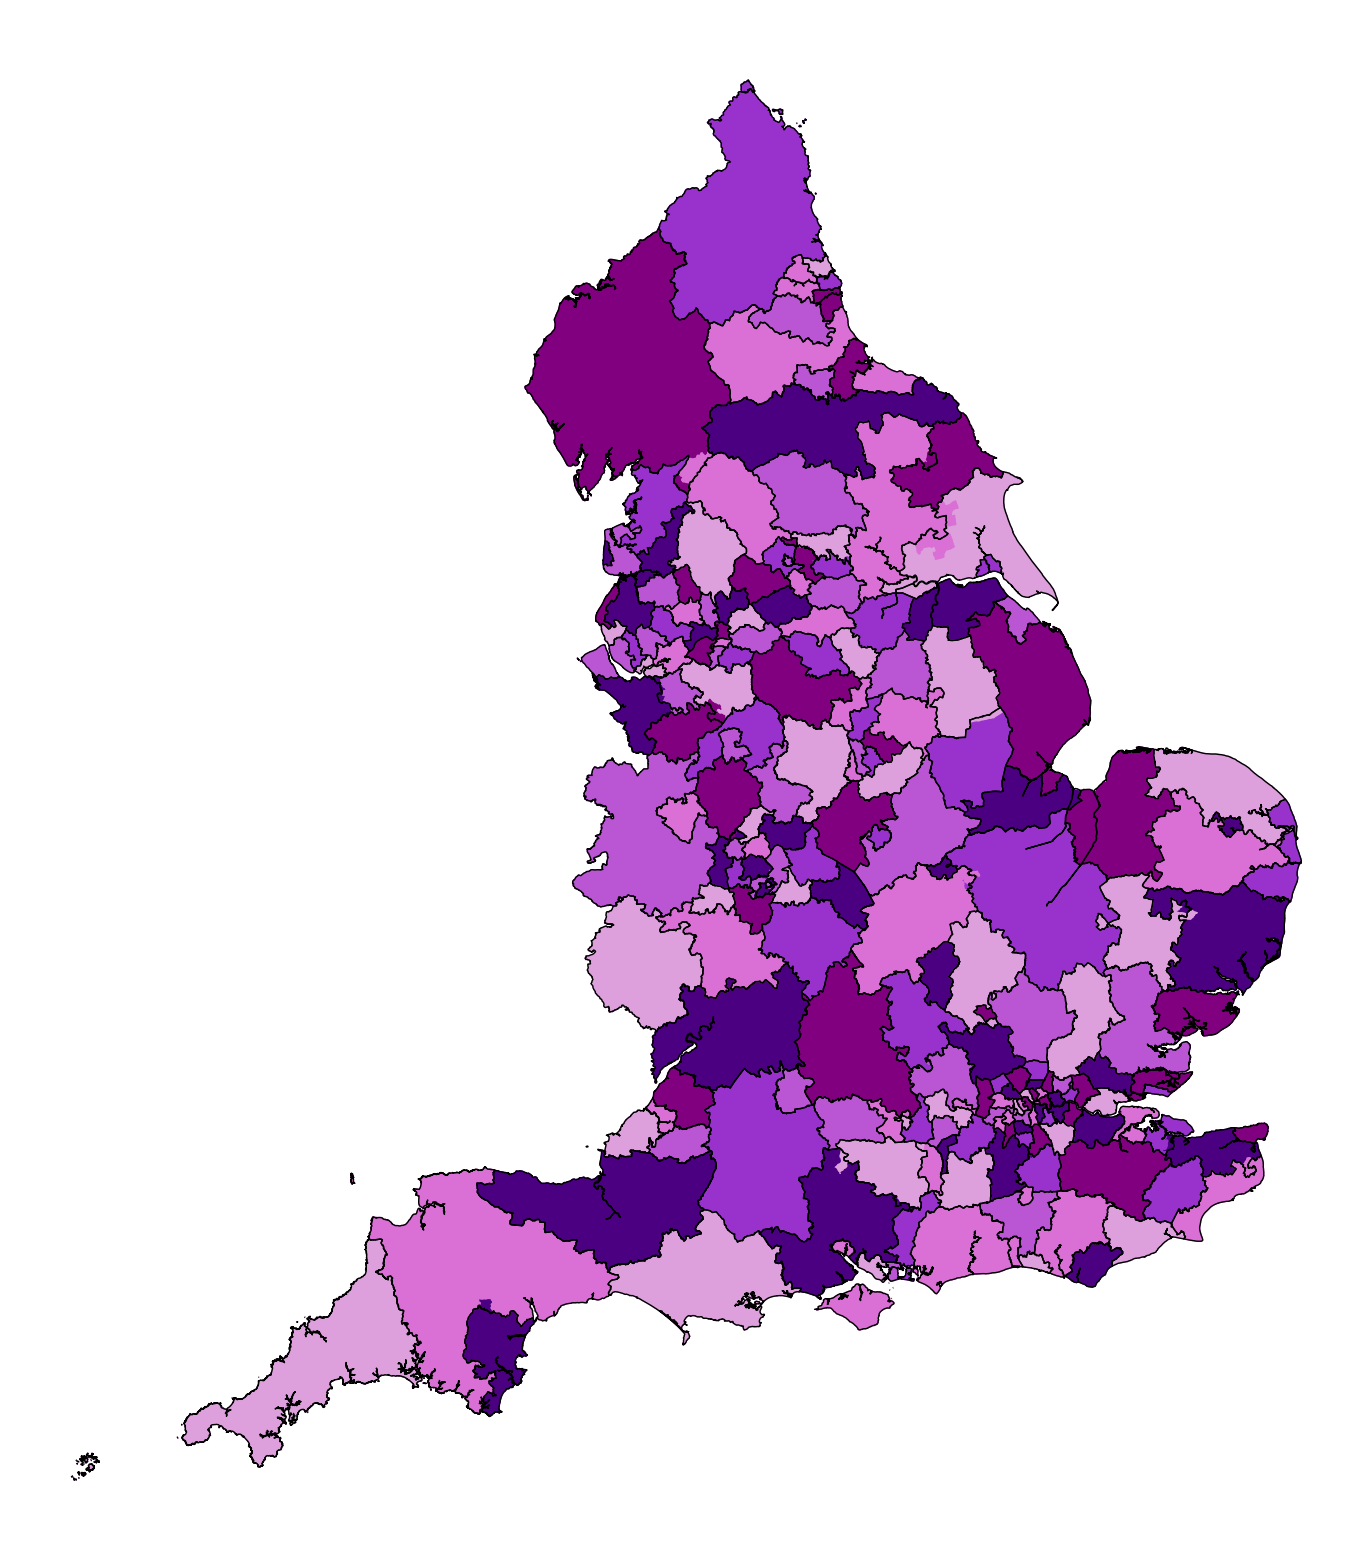

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_ward.plot(ax=ax, edgecolor='face', facecolor=gdf_ward['colour_str'])
gdf_ccg.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')

plt.savefig(os.path.join(paths.dir_output_images, paths.image_output), bbox_inches='tight')
plt.show()